In [1]:
#---------------------------------- IMPORTING ---------------------------------- 

%matplotlib notebook
import rebound
import numpy as np
import sys
from IPython.display import display, clear_output
from math import sqrt, log10, sin, cos, atan
import random as rnd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from tqdm import tqdm,tnrange
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from astropy import constants as const, units as u

In [2]:
#---------------------------------- CONSTANTS ---------------------------------- 
pc = (1.0*u.pc).to('AU').value

#All masses initialized in solar mass units:
m_hole = 4.0e6
m_bulge = 3.76e9
m_disk = 6.0e10
m_halo = 1.0e12

#Velocity cutoff
vel_cutoff = (1500.*u.km/u.s).to('AU/yr').value*2.0*np.pi

#All distances initialized in AU:
r_halo = 4.125e9
#r_peri = (4.0 * u.AU).to('km').value

#Bulge and disk parameters
ab = 2.0e7
ad = 5.7e8
bd = 6.2e7

#Nuclear cluster parameters
rc = 1.0*pc

#Additional constants
#scale = 1.6e9 # 8 kpc converted to AU
scale = (1.0e3 * u.pc).to('AU').value #1 kpc converted to AU
km_Solrad = (1.0 * u.km).to('R_sun').value #1 km converted to solar radii
AU_km = (1.0 * u.AU).to('km').value #1 AU converted to km
Mj = (9.54e-4 * u.M_sun).value #Mass of jupiter in solar mass units

In [3]:
#---------------------------------- DEFINING ---------------------------------- 

#Galaxy potential, taken from http://adsabs.harvard.edu/abs/2014ApJ...793..122K
#Note: There is a typo in that paper where "a_d" is said to be 2750 kpc, 
#it should be 2.75 kpc.

def migrationAccel(reb_sim):
    r = sqrt(ps[1].x**2+ps[1].y**2+ps[1].z**2)
    rho2 = ps[1].x**2+ps[1].y**2
    zbd = sqrt(ps[1].z**2+bd**2)
    
    #Components of halo force; smoothing function is necessary for integrator 
    #to handle logterm
    logterm = np.log(1.0+(r/r_halo))
    rterm = (r + r_halo)*(r**2)
    smoothing_func = lambda r: ((1.0/np.pi)*atan((r-1.0e8)/1.0e4) + 0.5)
    
    cluster_force = lambda r, coord: -2*m_hole * coord/(max(rc, r)*r**2)
    bulge_force = lambda r, coord: -m_bulge * coord/(r * (ab+r)**2)
    disk_force = lambda r, coord: -m_disk * coord/(rho2 + (ad + zbd)**2)**1.5
    halo_force = lambda r, coord: m_halo * coord *\
        ((logterm/r**3)-(1.0/rterm))*smoothing_func(r)
    
    ps[1].ax += cluster_force(r, ps[1].x) + bulge_force(r, ps[1].x) + disk_force(r, ps[1].x) + halo_force(r, ps[1].x)
    ps[1].ay += cluster_force(r, ps[1].x) + bulge_force(r, ps[1].y) + disk_force(r, ps[1].y) + halo_force(r, ps[1].y)
    ps[1].az += cluster_force(r, ps[1].x) + bulge_force(r, ps[1].z) + disk_force(r, ps[1].z) + halo_force(r, ps[1].z)

    #print(m_bulge, m_disk, m_halo)
    #sys.exit()
    
#Star mass determined from Salpeter's equation: Xi(m) =  1/(m**2.35)
#Integrating Xi(m') from -infty to m gives CDF(m) = 1/(m**1.35),
#produces a probability between [0,1].
#mstar_func(x) takes CDF(m) and solves for m as a function of probability 0 <= x <= 1. 

#mstar_func = lambda x: (1.0/x**1.35 * u.M_sun).value
n = -2.35
x0 = 100.0
x1 = 0.1
def M(y):
    return ((x1**(n+1.) - x0**(n+1.))*y + x0**(n+1.))**(1./(n+1.))

#Star radius determined via mass-radius power law, returns value in km units
#From http://faculty.buffalostate.edu/sabatojs/courses/GES639/S10/reading/mass_luminosity.pdf:
def rstar_func(m_star):
    return m_star**0.8
#     if m_star <= 1.66:
#         r = m_star**0.945
#     else: 
#         r = m_star**0.55
    
#     return r

#Binding energy spread, dependent on r of fragment (from Kochanek 1993)
Delta_E = lambda r, r_peri: 0.01*m_hole*r/(r_peri**2) #slowest one percent of particles

#The tidal radius (in km) for the star, with m_star and r_star being in solar mass 
#and radii, respectively (from Rees paper):
r_tidal = lambda m_star, r_star: r_star*(m_hole/m_star)**(1.0/3.0)

In [4]:
#---------------------------------- INTEGRATING ---------------------------------- 
Nstars = 2
nfrag = 10
Nout = 100

t_start = 0.0
t_end = 10000.0

posx = [[[] for y in range(nfrag)] for x in range(Nstars)]
posy = [[[] for y in range(nfrag)] for x in range(Nstars)]
posz = [[[] for y in range(nfrag)] for x in range(Nstars)]

star_masses=[]
star_radii=[]
tidal_radii=[]
sphere_points=[]

for star in tnrange(Nstars, desc='Star', leave=False):
    #Draw mass and radius of the star, determine tidal radius of star
    x = rnd.uniform(0.0,0.)
    #m_star = mstar_func(x) #in solar masses
    m_star=1.0
    star_masses.append(m_star)
    r_star = const.R_sun.to('AU').value*rstar_func(m_star)
    star_radii.append(r_star)
    r_t = r_tidal(m_star, r_star)
    
    tidal_radii.append(r_t)
    
    #Set position of star; random sphere point picking
    u1 = rnd.uniform(-1.0, 1.0)
    th1 = rnd.uniform(0., 2.*np.pi)
    star_vec = np.array([r_t*sqrt(1.0-(u1)**2)*cos(th1),\
                         r_t*sqrt(1.0-(u1)**2)*sin(th1),\
                         r_t*u1]) #star is a distance r_t from hole
    sphere_points.append(star_vec)
    
    #Set distances of each fragment              
    rads = [r_star*float(f)/float(nfrag+1) for f in range(nfrag+1)]
    rads.pop(0)
    
    #Velocity spread for star fragments, determined by binding energy
    vels = [sqrt(2*m_hole/r_t + 2*Delta_E(r, r_t)) for r in rads] #in km/s

    phi2 = rnd.uniform(0., 2.*np.pi)
    
    x = star_vec[0]
    y = star_vec[1]
    z = star_vec[2]
    r = np.linalg.norm(star_vec)
    
    randomvelvec = [
        (x*(r-z+z*cos(phi2))-r*y*sin(phi2))/(r**2*sqrt(2.0-2.0*z/r)),
        (y*(r-z+z*cos(phi2))+r*x*sin(phi2))/(r**2*sqrt(2.0-2.0*z/r)),
        ((r-z)*z-(x**2+y**2)*cos(phi2))/(r**2*sqrt(2.0-2.0*z/r))
    ]
    
#     vec2 = [sqrt(1.0-(u2)**2)*cos(th2),\
#             sqrt(1.0-(u2)**2)*sin(th2),\
#             u2]
    velocity_vec = np.cross(star_vec, randomvelvec)
    n = np.linalg.norm(velocity_vec)
    
    for frag in tnrange(nfrag, desc='Fragment', leave=False):
#         #Draw mass of fragments, from random normal dist. of clump masses centered around
#         #mean mass specified in Coughlin 2016 for gamma = 2
#         mu, sigma = 2.6*Mj, 0.3*Mj # mean and standard deviation
#         m_frag = (np.random.normal(mu, sigma)*u.Msun).value
                        
        #Finalize velocity vector of fragment
        vel = vels[frag]
        frag_velvec = [vel*v/n for v in velocity_vec]
        
        # Set up simulation
        sim = rebound.Simulation()
        #sim.G = Gg
        sim.integrator = "ias15"
        #sim.ri_whfast.corrector = 11
        sim.add(m=m_hole)
        
        #Add particle
        sim.add(m=0.0, x=star_vec[0],y=star_vec[1],z=star_vec[2],\
               vx=frag_velvec[0],vy=frag_velvec[1],vz=frag_velvec[2])
#         sim.add(m=0.0, x=r_t,y=0,z=0,\
#                 vx=0,vy=vel,vz=0)
        sim.N_active = 1
        sim.additional_forces = migrationAccel
        sim.force_is_velocity_dependent = 1
        ps = sim.particles

        times = np.linspace(0.0, 1.0e9*2.0*np.pi, Nout)
        for ti, time in enumerate(times):
            sim.integrate(time, exact_finish_time=1)
            posx[star][frag].append(ps[1].x/scale)
            posy[star][frag].append(ps[1].y/scale)
            posz[star][frag].append(ps[1].z/scale)
            
            if np.linalg.norm([ps[1].x, ps[1].y, ps[1].z])/scale > 20:
                break
                
            if 0 < 2*ps[1].a/scale and 2*ps[1].a/scale < 5.0:
                break
                
#             if np.dot([ps[1].x, ps[1].y, ps[1].z], [ps[1].vx, ps[1].vy, ps[1].vz])<0 and \
#             np.linalg.norm([ps[1].x, ps[1].y, ps[1].z])/scale < 1:
#                 break

In [ ]:
#---------------------------------- CHECKING ---------------------------------- 
print (star_masses)
print (m_hole)
print (r_t)
print (vel)
#print (star_radii)
print (vels)
#print (posx[0][0])
#print scale

In [ ]:
#---------------------------------- SPHERE POINTS ---------------------------------- 
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
for posvec in sphere_points:
    xs = posvec[0]
    ys = posvec[1]
    zs = posvec[2]
    ax1.scatter(xs, ys, zs, c='r', marker='o')
    
#ax1.set_aspect('equal')
ax1.set_xlabel('X Label')
ax1.set_ylabel('Y Label')
ax1.set_zlabel('Z Label')

plt.show()

<IPython.core.display.Javascript object>


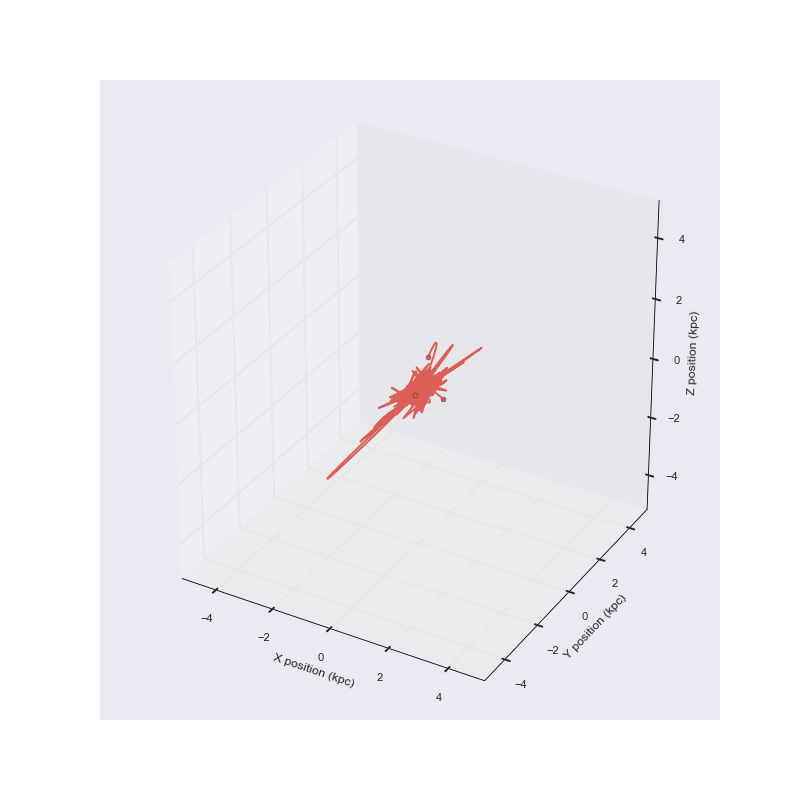

(-5, 5)

In [5]:
#---------------------------------- PLOTTING ---------------------------------- 

fig2 = plt.figure(figsize=(10,10))
ax2 = fig2.add_subplot(111, projection='3d')
colors = sns.color_palette("hls", Nstars).as_hex()

for star in range(Nstars):
    for i in range(nfrag):
        if len(posx[star][i]) < Nout:
            continue
        ax2.plot(posx[star][i],posy[star][i],posz[star][i], c = colors[star]);
        ax2.scatter([posx[star][i][-1]],[posy[star][i][-1]],[posz[star][i][-1]],\
                    c = colors[star]);

ax2.set_xlabel('X position (kpc)')
ax2.set_ylabel('Y position (kpc)')
ax2.set_zlabel('Z position (kpc)')

box_size = 5
ax2.set_xlim(-box_size,box_size)
ax2.set_ylim(-box_size,box_size)
ax2.set_zlim(-box_size,box_size)

<IPython.core.display.Javascript object>


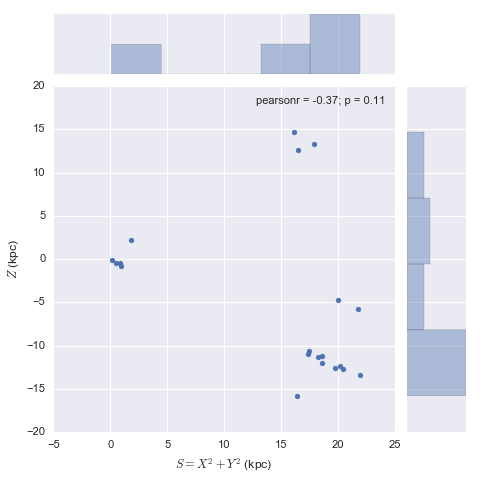

<IPython.core.display.Javascript object>


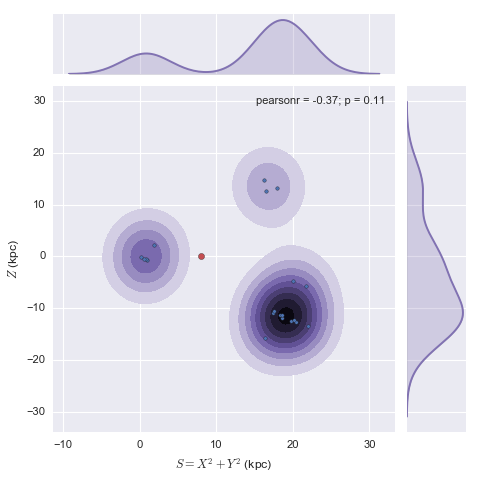

<IPython.core.display.Javascript object>


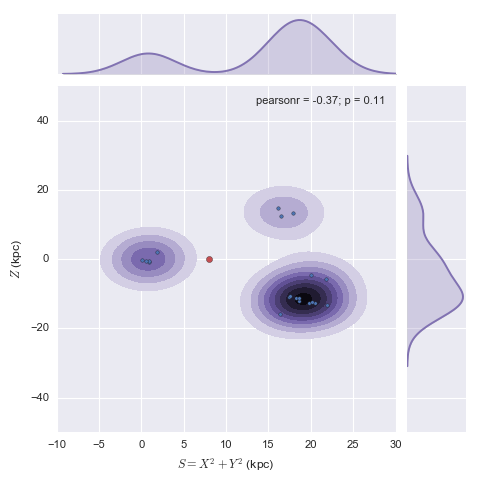

In [6]:
#---------------------------------- VISUALIZING ---------------------------------- 
data_sz = []
data_xy_0=[]

for star in range(Nstars):
    for i in range(nfrag):
        point1 = [sqrt(posx[star][i][-1]**2 + posy[star][i][-1]**2), posz[star][i][-1]]
        point2 = [posx[star][i][-1], posy[star][i][-1], posz[star][i][-1]]
        data_sz.append(point1)
#         if -1.0 < point2[2] and point2[2] < 1.0: #plot points within a kpc of the sun in the z-direction
#             data_xy_0.append([point2[0],point2[1]])
        
fragdata_sz = np.array([point for point in data_sz])
df_sz = pd.DataFrame(fragdata_sz, columns=["s", "z"])

# fragdata_xy_0 = np.array([point for point in data_xy_0])
# df_xy_0 = pd.DataFrame(fragdata_xy_0, columns=["x", "y"])

sun_pos_sz = pd.DataFrame([[8,0]], columns=['s', 'z'])
# sun_pos_xy = pd.DataFrame([[8,0]], columns=['x', 'y'])

#Scatter plots - S (sqrt(X**2+Y**2)) and Z
f = sns.jointplot(x="s", y="z", data=df_sz);
f.set_axis_labels("$S = X^2 + Y^2$ (kpc)", "$Z$ (kpc)");

#Density plot - S and Z
g = sns.jointplot(x="s", y="z", data=df_sz, kind="kde", color="m")
g.plot_joint(plt.scatter, c="b", s=10, marker="o")
g.x = sun_pos_sz.s
g.y = sun_pos_sz.z
g.plot_joint(plt.scatter, c="r", s=30, marker="o")

g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$S = X^2 + Y^2$ (kpc)", "$Z$ (kpc)");

#Density plot - S and Z
h = sns.jointplot(x="s", y="z", data=df_sz, kind="kde", color="m", xlim=(-10, 30), ylim=(-50,50))
h.plot_joint(plt.scatter, c="b", s=10, marker="o")
h.x = sun_pos_sz.s
h.y = sun_pos_sz.z
h.plot_joint(plt.scatter, c="r", s=30, marker="o")

h.ax_joint.collections[0].set_alpha(0)
h.set_axis_labels("$S = X^2 + Y^2$ (kpc)", "$Z$ (kpc)");

# #Density plot - X and Y
# h = sns.jointplot(x="x", y="y", data=df_xy_0, kind="kde", color="m")
# h.plot_joint(plt.scatter, c="b", s=10, marker="o")
# h.x = sun_pos_xy.x
# h.y = sun_pos_xy.y
# h.plot_joint(plt.scatter, c="r", s=30, marker="o")

# h.ax_joint.collections[0].set_alpha(0)
# h.set_axis_labels("$X$ (kpc), $Z\approx 0$", "$Y$ (kpc), $Z\approx 0$");